In [1]:
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from pandas.tools import plotting
import os.path as osp
import os
import logging
import gzip
from glob import glob
logging.getLogger().setLevel('INFO')

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')
    output.write(url.read())
    output.close()

In [3]:
BASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'
DATA_DIR = 'covtype'

DATA_URL = BASE_URL + DATA_DIR + "/covtype.data.gz"

os.makedirs(osp.join(DATA_DIR, 'archives'), exist_ok=True)

logging.info("downloading & extracting file %s", DATA_URL)
archive_path = osp.join(DATA_DIR, 'archives', osp.basename(DATA_URL))
download_file(DATA_URL, archive_path)

INFO:root:downloading & extracting file https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz


In [4]:
features_names = {'Elevation':[0],'Aspect':[1],'Slope':[2],
                  'Horizontal_Distance_To_Hydrology':[3],
                  'Vertical_Distance_To_Hydrology':[4],
                  'Horizontal_Distance_To_Roadways':[5],
                  'Hillshade_9am':[6],'Hillshade_Noon':[7],
                  'Hillshade_3pm':[8],
                  'Horiontal_Distance_To_Fire_Points':[9],
                  'Wilderness_Area':[10,11,12,13],
                  'Soil_Type':list(range(14,54)),
                  'Cover_Type':[54]}

def convert_to_listofint(df_attribut):
    return [[int(x) for x in X.split()] for X in df_attribut]

def convert_to_int(df_attribut):
    return [int(x) for x in df_attribut]

In [5]:
df_covtype = pd.read_csv(archive_path,header=None,
                         parse_dates=features_names,
                         compression='gzip')

for attribut in features_names:
    if attribut in ['Wilderness_Area','Soil_Type']:
        df_covtype[attribut] = convert_to_listofint(df_covtype[attribut])
    else:
        df_covtype[attribut] = convert_to_int(df_covtype[attribut])

In [6]:
df_covtype.groupby('Cover_Type').mean()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiontal_Distance_To_Fire_Points
Cover_Type,,,,,,,,,,
1,3128.644888,156.138227,13.127110,270.555245,42.156939,2614.834517,211.998782,223.430211,143.875038,2009.253517
2,2920.936061,152.060515,13.550499,279.916442,45.884219,2429.530799,213.844423,225.326596,142.983466,2168.154849
3,2394.509845,176.372490,20.770208,210.276473,62.446915,943.940734,201.918415,215.826537,140.367176,910.955949
4,2223.939934,137.139425,18.528941,106.934838,41.186749,914.199490,228.345832,216.997088,111.392792,859.124135
5,2787.417571,139.283051,16.641315,212.354893,50.610344,1349.765722,223.474876,219.035816,121.920889,1577.719794
6,2419.181897,180.539068,19.048886,159.853458,45.437439,1037.169805,192.844302,209.827662,148.284044,1055.351471
7,3361.928669,153.236226,14.255924,356.994686,69.474305,2738.250463,216.967723,221.746026,134.932033,2070.031594


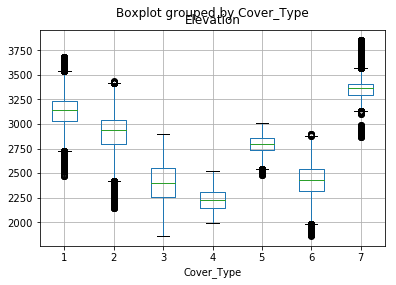

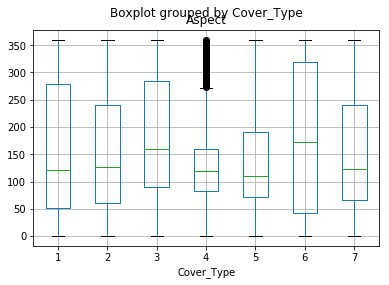

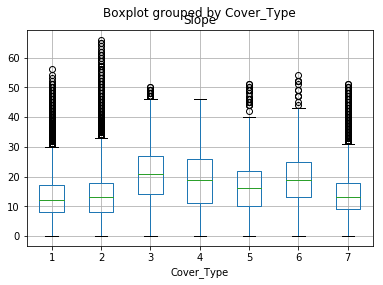

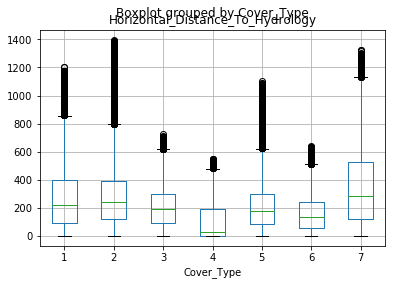

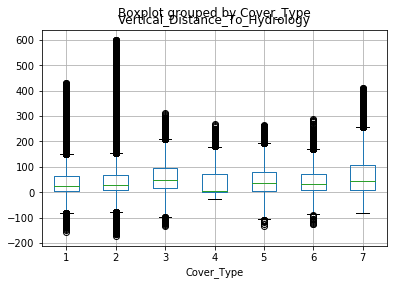

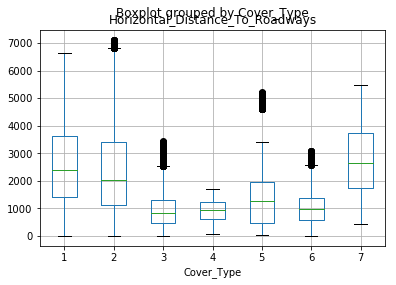

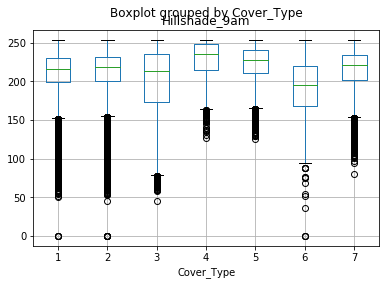

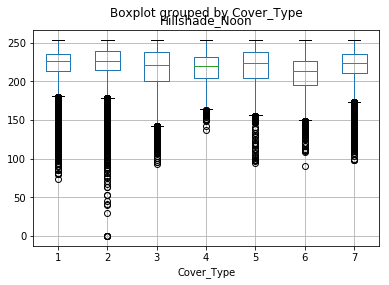

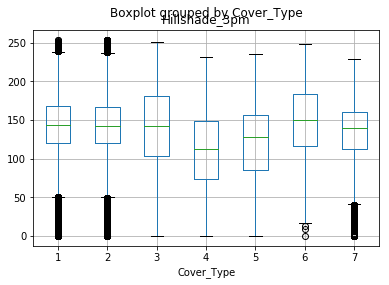

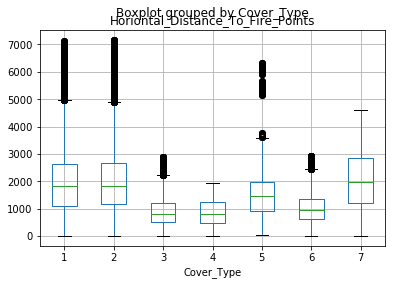

In [ ]:
for attribut in features_names:
    if attribut is ['Wilderness_Area','Soil_Type']:
        print('oups')
    else:
        df_covtype.boxplot(column=attribut,by='Cover_Type')
        plt.show()